In [3]:
#Name(s) here
#Mark Simmons
#mjs5839

# Association Analysis

Association analysis uses machine learning algorithms to extract hidden relationships from large datasets. In this assignment we'll be using one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

The data we'll use comes from a bakery called "The Bread Basket", located in the historic center of Edinburgh. The dataset contains more than 9000 transactions from the bakery. The file contains the following columns:

- Date. Categorical variable that tells us the date of the transactions (YYYY-MM-DD format). The column includes dates from 2016-10-30 to 2017-04-09.

- Time. Categorical variable that tells us the time of the transactions (HH:MM:SS format).

- Transaction. Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction.

- Item. Categorical variable with the products purchased.

## Installation
`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; you can follow the instructions below, or see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).


### Conda

Most of you should use Conda to do the install. If you downladed Anaconda in order to get Jupyter Notebooks (which is the most common way to get Jupyter Notebooks), then you will want to install `MLxtend` using Conda. 

Open a command prompt / terminal window and type:

`conda install mlxtend --channel conda-forge`

### PyPi

You can also install via pip. Note: If you are running Jupyter notebooks through an Anaconda install, then pip may not place the `MLxtend` libraries in the correct place for use in Jupyter. 

Open a command prompt / terminal window and type:

`pip3 install mlxtend`


## Apriori Algorithm

The Apriori algorithm is a classical algorithm in data mining. It is used for mining frequent itemsets and relevant association rules. In this part, you'll be running this algorithm for generating the itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [22]:
# Standard imports (you can add additional headers if you wish)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from math import isclose

In [5]:
%matplotlib inline

In [6]:
# Reading the dataset from file
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()[1:]
    transactions = []
    prev_tid = -1
    for t in content:
        t = t.strip().split(',')[-2:]
        tid = t[0]
        item = t[1]
        if prev_tid != tid:
            prev_tid = tid
            transactions.append([item])
        else:
            transactions[-1].append(item)
    return transactions

In [7]:
dataset = load_dataset('BreadBasket_DMS.csv')
#dataset is a 2D list
print("Num transactions:", len(dataset))
#Print the first 10 transactions
dataset[:10]

Num transactions: 9531


[['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna']]

**Q1.** Many transactions in the dataset include the item "NONE." First, find and remove all the "NONE" items from the dataset.

Once you have removed the NONEs, find the top 10 best-selling items in the bakery. Create a bar chart to display the total number of transactions for each of the top 10 selling items. Sort the bar chart by frequency (the top most sold item first, down to the 10th most sold item).

In [8]:
# your code goes here
for transaction in dataset:
    if "NONE" in transaction:
        transaction.remove("NONE")

**Q2.** 

a.) Using `mlxtend.preprocessing.TransactionEncoder` transform `dataset` into an array format suitable for the `mlxtend` library. You will need to call `fit` then `transform`. 

`TransactionEncoder` learns unique items from the dataset and transforms each transaction into a one-hot encoded boolean numpy array. For example, the resulting encoded dataset will be represented by something like this, where each row is a transaction. If the first transaction contained ['Crepe', 'Jam'], this would correspond to the first row in the encoded table. 

<img src="table.png">

Print the `shape` of the resulting encoded numpy array.

b.) `TransactionEncoder` also has a function `inverse_transform` that allows you to tranform one-hot encoded transactions back to the item labels. Try it out on the first 5 transactions and display the items in the first 5 transactions.

In [9]:
# your code goes here
trans_encoder = TransactionEncoder()
encoded_trans = trans_encoder.fit(dataset).transform(dataset)
print(encoded_trans.shape)
items = trans_encoder.inverse_transform(encoded_trans[:5])
items

(9531, 95)


[['Bread'],
 ['Scandinavian'],
 ['Cookies', 'Hot chocolate', 'Jam'],
 ['Muffin'],
 ['Bread', 'Coffee', 'Pastry']]

**Q3.** Convert the encoded numpy array from Q2 part a into a pandas dataframe. Use the `TransactionEncoder`'s `.columns_` attribute as the column headers. Print the head of the resulting dataframe. 

In [10]:
# your code goes here
data = pd.DataFrame(data=encoded_trans, columns=trans_encoder.columns_)
data.head()

Adjustment  Afternoon with the baker  Alfajores  Argentina Night  Art Tray  \
0       False                     False      False            False     False   
1       False                     False      False            False     False   
2       False                     False      False            False     False   
3       False                     False      False            False     False   
4       False                     False      False            False     False   

   Bacon  Baguette  Bakewell  Bare Popcorn  Basket  ...  The BART  The Nomad  \
0  False     False     False         False   False  ...     False      False   
1  False     False     False         False   False  ...     False      False   
2  False     False     False         False   False  ...     False      False   
3  False     False     False         False   False  ...     False      False   
4  False     False     False         False   False  ...     False      False   

   Tiffin  Toast  Truffles  Tshirt  Valentine's card  Vegan Feast  \
0   False  False     False   False             False        False   
1   False  False     False   False             False        False   
2   False  False     False   False             False        False   
3   False  False     False   False             False        False   
4   False  False     False   False             False        False   

   Vegan mincepie  Victorian Sponge  
0           False             False  
1           False             False  
2           False             False  
3           False             False  
4           False             False  

[5 rows x 95 columns]

**Q4.** Use the `mlxtend.frequent_patterns.apriori` to generate the frequent itemsets with minimum support of 1%. Display these itemsets along with their support values.

In [11]:
# your code goes here
freq_sets = apriori(data, min_support=0.01, use_colnames=True)
freq_sets

support                  itemsets
0   0.036093               (Alfajores)
1   0.015948                (Baguette)
2   0.324940                   (Bread)
3   0.039765                 (Brownie)
4   0.103137                    (Cake)
5   0.012905            (Chicken Stew)
6   0.475081                  (Coffee)
7   0.019305                    (Coke)
8   0.054034                 (Cookies)
9   0.038926              (Farm House)
10  0.014899                   (Fudge)
11  0.010492       (Hearty & Seasonal)
12  0.057916           (Hot chocolate)
13  0.014899                     (Jam)
14  0.013115          (Jammie Dodgers)
15  0.038296                   (Juice)
16  0.061379               (Medialuna)
17  0.014059           (Mineral water)
18  0.038191                  (Muffin)
19  0.085510                  (Pastry)
20  0.010387                   (Salad)
21  0.071346                (Sandwich)
22  0.028853            (Scandinavian)
23  0.034309                   (Scone)
24  0.034204                    (Soup)
25  0.018046          (Spanish Brunch)
26  0.141643                     (Tea)
27  0.015318                  (Tiffin)
28  0.033365                   (Toast)
29  0.020145                (Truffles)
30  0.010282        (Bread, Alfajores)
31  0.019515       (Coffee, Alfajores)
32  0.010702          (Brownie, Bread)
33  0.023187             (Cake, Bread)
34  0.089393           (Coffee, Bread)
35  0.014374          (Cookies, Bread)
36  0.013325    (Hot chocolate, Bread)
37  0.016787        (Medialuna, Bread)
38  0.028958           (Pastry, Bread)
39  0.016892         (Sandwich, Bread)
40  0.027909              (Bread, Tea)
41  0.019515         (Coffee, Brownie)
42  0.054349            (Coffee, Cake)
43  0.011331     (Cake, Hot chocolate)
44  0.023607               (Cake, Tea)
45  0.028014         (Coffee, Cookies)
46  0.029378   (Coffee, Hot chocolate)
47  0.020460           (Coffee, Juice)
48  0.034939       (Coffee, Medialuna)
49  0.018676          (Coffee, Muffin)
50  0.047214          (Pastry, Coffee)
51  0.037981        (Sandwich, Coffee)
52  0.017941           (Coffee, Scone)
53  0.015738            (Coffee, Soup)
54  0.010807  (Coffee, Spanish Brunch)
55  0.049523             (Coffee, Tea)
56  0.023502           (Toast, Coffee)
57  0.014269           (Sandwich, Tea)
58  0.011122   (Pastry, Coffee, Bread)

**Q5.** Using the frequent itemsets and support counts in Q4, find and display all the maximal frequent itemsets along with their support fraction. Also print a count of how many maximal frequent itemsets you have found.

In [12]:
# your code goes here
def is_maximal(itemset):
    for x in freq_sets['itemsets']:
        if x is itemset:
            continue
        elif all(item in x for item in itemset):
            return False
    else:
        return True
maximal_sets = freq_sets[[is_maximal(itemset) for itemset in freq_sets['itemsets']]]
print(maximal_sets.shape)
maximal_sets

(39, 2)


support                  itemsets
1   0.015948                (Baguette)
5   0.012905            (Chicken Stew)
7   0.019305                    (Coke)
9   0.038926              (Farm House)
10  0.014899                   (Fudge)
11  0.010492       (Hearty & Seasonal)
13  0.014899                     (Jam)
14  0.013115          (Jammie Dodgers)
17  0.014059           (Mineral water)
20  0.010387                   (Salad)
22  0.028853            (Scandinavian)
27  0.015318                  (Tiffin)
29  0.020145                (Truffles)
30  0.010282        (Bread, Alfajores)
31  0.019515       (Coffee, Alfajores)
32  0.010702          (Brownie, Bread)
33  0.023187             (Cake, Bread)
35  0.014374          (Cookies, Bread)
36  0.013325    (Hot chocolate, Bread)
37  0.016787        (Medialuna, Bread)
39  0.016892         (Sandwich, Bread)
40  0.027909              (Bread, Tea)
41  0.019515         (Coffee, Brownie)
42  0.054349            (Coffee, Cake)
43  0.011331     (Cake, Hot chocolate)
44  0.023607               (Cake, Tea)
45  0.028014         (Coffee, Cookies)
46  0.029378   (Coffee, Hot chocolate)
47  0.020460           (Coffee, Juice)
48  0.034939       (Coffee, Medialuna)
49  0.018676          (Coffee, Muffin)
51  0.037981        (Sandwich, Coffee)
52  0.017941           (Coffee, Scone)
53  0.015738            (Coffee, Soup)
54  0.010807  (Coffee, Spanish Brunch)
55  0.049523             (Coffee, Tea)
56  0.023502           (Toast, Coffee)
57  0.014269           (Sandwich, Tea)
58  0.011122   (Pastry, Coffee, Bread)

**Q6.** Using the frequent itemsets and support counts in Q4, find all the closed frequent itemsets along with their support fraction. Also print a count of how many closed frequent itemsets you have found.

In [23]:
# your code goes here
def is_closed(row):
    itemset = row['itemsets']
    support = row['support']
    for index, row in freq_sets.iterrows():
        if itemset is row['itemsets']:
            continue
        if all(x in row['itemsets'] for x in itemset) and isclose(support, row['support']):
            return False
    else:
        return True

closed_freq = freq_sets[[is_closed(row) for index, row in freq_sets.iterrows()]]
print(closed_freq.shape)
closed_freq

(59, 2)


support                  itemsets
0   0.036093               (Alfajores)
1   0.015948                (Baguette)
2   0.324940                   (Bread)
3   0.039765                 (Brownie)
4   0.103137                    (Cake)
5   0.012905            (Chicken Stew)
6   0.475081                  (Coffee)
7   0.019305                    (Coke)
8   0.054034                 (Cookies)
9   0.038926              (Farm House)
10  0.014899                   (Fudge)
11  0.010492       (Hearty & Seasonal)
12  0.057916           (Hot chocolate)
13  0.014899                     (Jam)
14  0.013115          (Jammie Dodgers)
15  0.038296                   (Juice)
16  0.061379               (Medialuna)
17  0.014059           (Mineral water)
18  0.038191                  (Muffin)
19  0.085510                  (Pastry)
20  0.010387                   (Salad)
21  0.071346                (Sandwich)
22  0.028853            (Scandinavian)
23  0.034309                   (Scone)
24  0.034204                    (Soup)
25  0.018046          (Spanish Brunch)
26  0.141643                     (Tea)
27  0.015318                  (Tiffin)
28  0.033365                   (Toast)
29  0.020145                (Truffles)
30  0.010282        (Bread, Alfajores)
31  0.019515       (Coffee, Alfajores)
32  0.010702          (Brownie, Bread)
33  0.023187             (Cake, Bread)
34  0.089393           (Coffee, Bread)
35  0.014374          (Cookies, Bread)
36  0.013325    (Hot chocolate, Bread)
37  0.016787        (Medialuna, Bread)
38  0.028958           (Pastry, Bread)
39  0.016892         (Sandwich, Bread)
40  0.027909              (Bread, Tea)
41  0.019515         (Coffee, Brownie)
42  0.054349            (Coffee, Cake)
43  0.011331     (Cake, Hot chocolate)
44  0.023607               (Cake, Tea)
45  0.028014         (Coffee, Cookies)
46  0.029378   (Coffee, Hot chocolate)
47  0.020460           (Coffee, Juice)
48  0.034939       (Coffee, Medialuna)
49  0.018676          (Coffee, Muffin)
50  0.047214          (Pastry, Coffee)
51  0.037981        (Sandwich, Coffee)
52  0.017941           (Coffee, Scone)
53  0.015738            (Coffee, Soup)
54  0.010807  (Coffee, Spanish Brunch)
55  0.049523             (Coffee, Tea)
56  0.023502           (Toast, Coffee)
57  0.014269           (Sandwich, Tea)
58  0.011122   (Pastry, Coffee, Bread)

**Q7.** Use `mlxtend.frequent_patterns.association_rules` to calculate rules with a confidence level of 0.25 for the frequent itemsets you generated in Q4.

In [14]:
# your code goes here
rules = association_rules(freq_sets, metric='confidence', min_threshold=0.25)

**Q8.** An important step in generating a set of association rules is to determine the optimal thresholds for support and confidence. If we set these values too low we will get a lot of rules and most of them will not be useful. Generate the frequent itemsets with minimum support of 0.5% and plot the number of rules generated with respect to the confidence threshold by varying its value between 0 and 1 with increments of 0.1. What happens when we increase the confidence level? Why?

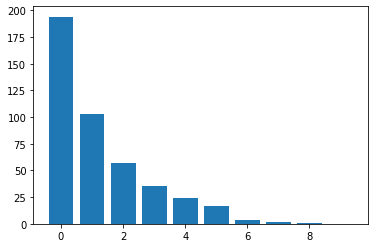

In [18]:
# your code goes here
new_freq_sets = apriori(data, min_support=0.005, use_colnames=True)
num_rules = []
for i in range(0, 10):
    rules = association_rules(new_freq_sets, metric='confidence', min_threshold=i/10)
    num_rules.append(len(rules))

plt.bar(x=range(0,10), height=num_rules)
plt.show()

**Q9.** What value would you choose for the minimum confidence threshold based on the plot in Q8? Why? Display the rules generated for your chosen value. Take a look at the generated rules. Are they interesting? Why/why not?

In [26]:
# your code goes here
# I chose a threshold of 0.2, as the number of rules it generates is similar to the number of frequent items
# The resultant rules, however, are not that interesting. They overwhelmingly state that any transaction is likely
# to include coffee, tea or bread, regardless of antecedent
# there are exactly three rules with a lift > 1 that predict a consequent that isn't coffee, tea or bread
# (coffee, tea) > (cake)
# (coffee, hot chocolate) > (cake)
# (coke) > (sandwich)
rules = association_rules(new_freq_sets, metric='confidence', min_threshold=0.2)
rules.sort_values(by='lift')

antecedents consequents  antecedent support  \
51             (Bread, Tea)    (Coffee)            0.027909   
4                   (Bread)    (Coffee)            0.324940   
45  (Coffee, Hot chocolate)     (Bread)            0.029378   
9                  (Muffin)     (Bread)            0.038191   
3                    (Cake)     (Bread)            0.103137   
12           (Scandinavian)     (Bread)            0.028853   
19                   (Coke)    (Coffee)            0.019305   
6           (Hot chocolate)     (Bread)            0.057916   
14                  (Toast)     (Bread)            0.033365   
48         (Pastry, Coffee)     (Bread)            0.047214   
11               (Sandwich)     (Bread)            0.071346   
35                    (Tea)    (Coffee)            0.141643   
44         (Cookies, Bread)    (Coffee)            0.014374   
38               (Truffles)    (Coffee)            0.020145   
56          (Sandwich, Tea)    (Coffee)            0.014269   
49          (Pastry, Bread)    (Coffee)            0.028958   
13                  (Scone)     (Bread)            0.034309   
5                 (Cookies)     (Bread)            0.054034   
2                 (Brownie)     (Bread)            0.039765   
27          (Mineral water)    (Coffee)            0.014059   
18           (Chicken Stew)    (Coffee)            0.012905   
8               (Medialuna)     (Bread)            0.061379   
47       (Medialuna, Bread)    (Coffee)            0.016787   
0               (Alfajores)     (Bread)            0.036093   
55              (Cake, Tea)    (Coffee)            0.023607   
50        (Sandwich, Bread)    (Coffee)            0.016892   
43            (Cake, Bread)    (Coffee)            0.023187   
46   (Hot chocolate, Bread)    (Coffee)            0.013325   
33                   (Soup)    (Coffee)            0.034204   
28                 (Muffin)    (Coffee)            0.038191   
15                (Brownie)    (Coffee)            0.039765   
7                     (Jam)     (Bread)            0.014899   
10                 (Pastry)     (Bread)            0.085510   
23         (Jammie Dodgers)    (Coffee)            0.013115   
22          (Hot chocolate)    (Coffee)            0.057916   
20                (Cookies)    (Coffee)            0.054034   
32                  (Scone)    (Coffee)            0.034309   
16                   (Cake)    (Coffee)            0.103137   
31               (Sandwich)    (Coffee)            0.071346   
24                  (Juice)    (Coffee)            0.038296   
21      (Hearty & Seasonal)    (Coffee)            0.010492   
1               (Alfajores)    (Coffee)            0.036093   
36                 (Tiffin)    (Coffee)            0.015318   
29                 (Pastry)    (Coffee)            0.085510   
26              (Medialuna)    (Coffee)            0.061379   
34         (Spanish Brunch)    (Coffee)            0.018046   
52    (Cake, Hot chocolate)    (Coffee)            0.011331   
30                  (Salad)    (Coffee)            0.010387   
40               (Sandwich)       (Tea)            0.071346   
37                  (Toast)    (Coffee)            0.033365   
17                   (Cake)       (Tea)            0.103137   
25       (Keeping It Local)    (Coffee)            0.006610   
41                  (Scone)       (Tea)            0.034309   
42                   (Soup)       (Tea)            0.034204   
54            (Coffee, Tea)      (Cake)            0.049523   
53  (Coffee, Hot chocolate)      (Cake)            0.029378   
39                   (Coke)  (Sandwich)            0.019305   

    consequent support   support  confidence      lift  leverage  conviction  
51            0.475081  0.007344    0.263158  0.553922 -0.005915    0.712390  
4             0.475081  0.089393    0.275105  0.579069 -0.064980    0.724131  
45            0.324940  0.006085    0.207143  0.637481 -0.003461    0.851427  
9             0.324940  0.008079    0.211538 